Using device: cuda ⚙️

--- Creating DataFrames ---
Successfully created and merged dataframes: 5364 train, 674 val, 664 test.

Loading all three models from specified paths...
All models loaded successfully! ✅

Generating predictions and collecting ground truths...


Segmentation Prediction: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]



Ensembling predictions...


--- Starting Classification Stage ---

Generating segmentation predictions for all datasets...


Generating Val Masks: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Segmentation predictions generated successfully for all splits.

Applying SMOTE to balance the training data...


Extracting features: 100%|██████████| 336/336 [00:41<00:00,  8.15it/s]


Original training data samples per class: [2179 2069 1116]
Resampled training data samples per class: [2179 2179 2179]

Classification datasets and loaders are ready.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s] 



--- Starting Classifier Training with Early Stopping ---


Epoch 1/50: 100%|██████████| 409/409 [00:40<00:00, 10.15it/s]


Epoch 1 | Loss: 0.4556 | Val Accuracy: 0.7611
    -> ✅ New best model saved with accuracy: 0.7611


Epoch 2/50: 100%|██████████| 409/409 [00:40<00:00, 10.22it/s]


Epoch 2 | Loss: 0.1349 | Val Accuracy: 0.7107
    -> ❌ No improvement for 1 epochs.


Epoch 3/50: 100%|██████████| 409/409 [00:39<00:00, 10.24it/s]


Epoch 3 | Loss: 0.0824 | Val Accuracy: 0.6958
    -> ❌ No improvement for 2 epochs.


Epoch 4/50: 100%|██████████| 409/409 [00:39<00:00, 10.24it/s]


Epoch 4 | Loss: 0.0445 | Val Accuracy: 0.7136
    -> ❌ No improvement for 3 epochs.


Epoch 5/50: 100%|██████████| 409/409 [00:40<00:00, 10.21it/s]


Epoch 5 | Loss: 0.0656 | Val Accuracy: 0.7418
    -> ❌ No improvement for 4 epochs.


Epoch 6/50: 100%|██████████| 409/409 [00:39<00:00, 10.23it/s]


Epoch 6 | Loss: 0.0399 | Val Accuracy: 0.7300
    -> ❌ No improvement for 5 epochs.

Early stopping triggered after 5 epochs with no improvement.

--- Training Finished ---

--- Evaluating on Test Set ---


Testing: 100%|██████████| 42/42 [00:10<00:00,  4.01it/s]



--- Classification Report ---
              precision    recall  f1-score   support

        Mild       0.82      0.91      0.86       350
    Moderate       0.12      0.08      0.10       133
      Severe       0.62      0.62      0.62       181

    accuracy                           0.67       664
   macro avg       0.52      0.54      0.53       664
weighted avg       0.63      0.67      0.65       664


--- Confusion Matrix ---


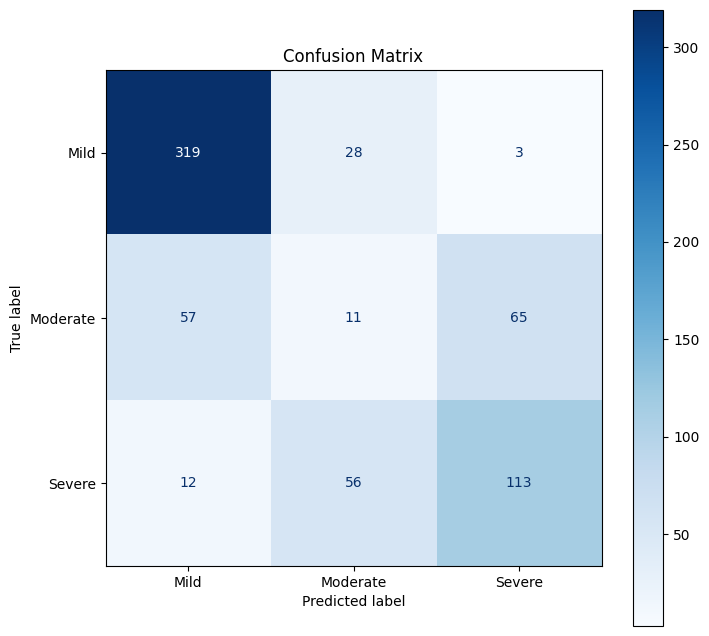

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# --- 1. CONFIGURATION ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
TRAIN_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
VAL_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
IMAGE_SIZE = (224, 224)

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

# --- 3. DATAFRAME CREATION AND MERGE ---
print("\n--- Creating DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir = os.path.join(folder_path, 'images')
                if os.path.exists(images_dir):
                    for image_file in os.listdir(images_dir):
                        mask_path = os.path.join(folder_path, 'masks', image_file)
                        if os.path.exists(mask_path):
                            image_path = os.path.join(images_dir, image_file)
                            data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    train_df = pd.merge(create_dataframe_from_ids(TRAIN_DIR, valid_ids), metadata_df, on='ID')
    val_df = pd.merge(create_dataframe_from_ids(VAL_DIR, valid_ids), metadata_df, on='ID')
    test_df = pd.merge(create_dataframe_from_ids(TEST_DIR, valid_ids), metadata_df, on='ID')

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more dataframes are empty. Check your file paths and metadata.")
    
    print(f"Successfully created and merged dataframes: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        label = torch.tensor(row['class_label'], dtype=torch.long)
        return image, mask, label

# --- 5. MODEL ARCHITECTURE DEFINITIONS ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        bs,_,h,w = e4.shape
        trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        return F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet50(weights=None)
        layers = list(base.children())
        self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.attn3 = AttentionGate(1024, 1024, 512)
        self.dec_conv3 = ConvBlock(2048, 1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.attn2 = AttentionGate(512, 512, 256)
        self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.attn1 = AttentionGate(256, 256, 128)
        self.dec_conv1 = ConvBlock(512, 256)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.attn0 = AttentionGate(64, 64, 32)
        self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1))
        d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1))
        d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1))
        return self.final_conv(self.final_up(d0))

# --- 6. LOADING MODELS ---
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except Exception as e:
        print(f"Error loading files: {e}")

# --- 7. PREDICTION & EVALUATION ---
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    all_preds1, all_preds2, all_preds3 = [], [], []
    print("\nGenerating predictions and collecting ground truths...")
    with torch.no_grad():
        for images, _, _ in tqdm(test_loader, desc="Segmentation Prediction"):
            images = images.to(device)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())

    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)

    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

# =================================================================================
# --- 8. CLASSIFICATION STAGE (Corrected with SMOTE and Early Stopping) ---
# =================================================================================

print("\n\n--- Starting Classification Stage ---")

if not models_loaded or test_df is None:
    print("Skipping classification stage due to errors in model or data loading.")
else:
    try:
        # --- 8.1 Generate Segmentation Predictions for all datasets ---
        print("\nGenerating segmentation predictions for all datasets...")
        
        train_dataset = LiverDataset(train_df, transform=test_transform)
        val_dataset = LiverDataset(val_df, transform=test_transform)

        def get_segmentation_predictions(dataset, desc):
            loader = DataLoader(dataset, batch_size=16, shuffle=False)
            all_preds = []
            with torch.no_grad():
                for images, _, _ in tqdm(loader, desc=desc):
                    images = images.to(device)
                    preds1 = model1(images)
                    preds2 = model2(images)
                    preds3 = model3(images)
                    ensembled = torch.sigmoid(torch.mean(torch.stack([preds1, preds2, preds3]), dim=0))
                    all_preds.append((ensembled > 0.5).float().cpu())
            return torch.cat(all_preds)

        train_pred_masks = get_segmentation_predictions(train_dataset, "Generating Train Masks")
        val_pred_masks = get_segmentation_predictions(val_dataset, "Generating Val Masks")
        test_pred_masks = (torch.sigmoid(ensembled_preds) > 0.5).float()

        print("Segmentation predictions generated successfully for all splits.")
        
        # --- 8.2 Prepare Data for Classification ---
        class RawClassificationDataset(Dataset):
            def __init__(self, dataframe, predicted_masks, transform):
                self.dataframe = dataframe
                self.predicted_masks = predicted_masks
                self.transform = transform
            def __len__(self): return len(self.dataframe)
            def __getitem__(self, idx):
                row = self.dataframe.iloc[idx]
                image_pil = Image.open(row['image_file_path']).convert('RGB')
                mask_pil = Image.open(row['mask_file_path']).convert('L')
                image, gt_mask = self.transform(image_pil, mask_pil)
                pred_mask = self.predicted_masks[idx]
                # Combined input now has 5 channels (RGB, GT mask, Pred mask)
                combined_input = torch.cat([image, gt_mask, pred_mask], dim=0)
                label = torch.tensor(row['class_label'], dtype=torch.long)
                return combined_input, label

        train_raw_dataset = RawClassificationDataset(train_df, train_pred_masks, test_transform)
        val_cls_dataset = RawClassificationDataset(val_df, val_pred_masks, test_transform)
        test_cls_dataset = RawClassificationDataset(test_df, test_pred_masks, test_transform)

        # --- 8.3 Apply SMOTE to training data ---
        print("\nApplying SMOTE to balance the training data...")
        X_train, y_train = [], []
        for inputs, labels in tqdm(DataLoader(train_raw_dataset, batch_size=16, shuffle=False), desc="Extracting features"):
            X_train.append(inputs.view(inputs.shape[0], -1))
            y_train.append(labels)
        
        X_train_flat = torch.cat(X_train, dim=0).cpu().numpy()
        y_train_labels = torch.cat(y_train, dim=0).cpu().numpy()
        
        print(f"Original training data samples per class: {np.bincount(y_train_labels)}")

        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train_flat, y_train_labels)
        
        print(f"Resampled training data samples per class: {np.bincount(y_train_res)}")
        
        # Reshape the resampled data and create a new DataLoader
        X_train_res = torch.from_numpy(X_train_res).float().view(-1, 5, IMAGE_SIZE[0], IMAGE_SIZE[1])
        y_train_res = torch.from_numpy(y_train_res).long()
        
        train_cls_dataset_smote = TensorDataset(X_train_res, y_train_res)
        train_cls_loader = DataLoader(train_cls_dataset_smote, batch_size=16, shuffle=True)
        val_cls_loader = DataLoader(val_cls_dataset, batch_size=16, shuffle=False)
        test_cls_loader = DataLoader(test_cls_dataset, batch_size=16, shuffle=False)
        print("\nClassification datasets and loaders are ready.")

        # --- 8.4 CLASSIFICATION MODEL ---
        class CirrhosisClassifier(nn.Module):
            def __init__(self, n_classes=3, in_channels=5):
                super().__init__()
                self.base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                original_conv1 = self.base_model.conv1
                self.base_model.conv1 = nn.Conv2d(in_channels, original_conv1.out_channels,
                                                  kernel_size=original_conv1.kernel_size, stride=original_conv1.stride,
                                                  padding=original_conv1.padding, bias=False)
                num_ftrs = self.base_model.fc.in_features
                self.base_model.fc = nn.Linear(num_ftrs, n_classes)
            def forward(self, x): return self.base_model(x)
        
        # --- 8.5 TRAINING & EVALUATION with Early Stopping ---
        cls_model = CirrhosisClassifier(n_classes=3, in_channels=5).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(cls_model.parameters(), lr=1e-4)
        num_epochs = 50  # We can set a higher number as we will use early stopping
        patience = 5  # Stop if validation accuracy doesn't improve for 5 epochs
        epochs_no_improve = 0
        best_val_accuracy = 0.0
        
        print("\n--- Starting Classifier Training with Early Stopping ---")
        for epoch in range(num_epochs):
            cls_model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = cls_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            cls_model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_cls_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = cls_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
            
            val_accuracy = val_corrects.double() / len(val_cls_dataset)
            print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_cls_loader):.4f} | Val Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(cls_model.state_dict(), 'best_classifier_model.pth')
                epochs_no_improve = 0
                print(f"    -> ✅ New best model saved with accuracy: {best_val_accuracy:.4f}")
            else:
                epochs_no_improve += 1
                print(f"    -> ❌ No improvement for {epochs_no_improve} epochs.")
            
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
                break

        print("\n--- Training Finished ---")

        # --- 8.6 FINAL EVALUATION ON TEST SET ---
        print("\n--- Evaluating on Test Set ---")
        cls_model.load_state_dict(torch.load('best_classifier_model.pth'))
        cls_model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(test_cls_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cls_model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        class_names = ['Mild', 'Moderate', 'Severe']
        print("\n--- Classification Report ---")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    except Exception as e:
        print(f"\nAn error occurred during the classification stage: {e}")

In [1]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install opencv-python-headless 
!pip install torch torchvision pandas numpy matplotlib seaborn opencv-python scikit-learn Pillow imblearn tqdm
!pip install pandas lime scikit-image -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 64.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-lea

Using device: cuda ⚙️

--- Creating DataFrames ---
Successfully created and merged dataframes: 5364 train, 674 val, 664 test.

Loading all three models from specified paths...
All models loaded successfully! ✅

Generating predictions and collecting ground truths...


Segmentation Prediction: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]



Ensembling predictions...


--- Starting Classification Stage ---

Generating segmentation predictions for all datasets...


Generating Val Masks: 100%|██████████| 43/43 [00:37<00:00,  1.15it/s]


Segmentation predictions generated successfully for all splits.

Applying SMOTE to balance the training data...


Extracting features: 100%|██████████| 1/1 [00:46<00:00, 46.68s/it]


Original training data samples per class: [2179 2069 1116]
Resampled training data samples per class: [2179 2179 2179]

Classification datasets and loaders are ready.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]



--- Starting Classifier Training with Early Stopping ---


Epoch 1/50: 100%|██████████| 409/409 [00:49<00:00,  8.34it/s]


Epoch 1 | Loss: 0.4596 | Val Accuracy: 0.7240
      -> ✅ New best model saved with accuracy: 0.7240


Epoch 2/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 2 | Loss: 0.1155 | Val Accuracy: 0.6276
      -> ❌ No improvement for 1 epochs.


Epoch 3/50: 100%|██████████| 409/409 [00:47<00:00,  8.65it/s]


Epoch 3 | Loss: 0.0793 | Val Accuracy: 0.6795
      -> ❌ No improvement for 2 epochs.


Epoch 4/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 4 | Loss: 0.0593 | Val Accuracy: 0.6320
      -> ❌ No improvement for 3 epochs.


Epoch 5/50: 100%|██████████| 409/409 [00:47<00:00,  8.66it/s]


Epoch 5 | Loss: 0.0387 | Val Accuracy: 0.6454
      -> ❌ No improvement for 4 epochs.


Epoch 6/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 6 | Loss: 0.0165 | Val Accuracy: 0.6780
      -> ❌ No improvement for 5 epochs.


Epoch 7/50: 100%|██████████| 409/409 [00:47<00:00,  8.68it/s]


Epoch 7 | Loss: 0.0274 | Val Accuracy: 0.6855
      -> ❌ No improvement for 6 epochs.


Epoch 8/50: 100%|██████████| 409/409 [00:47<00:00,  8.68it/s]


Epoch 8 | Loss: 0.0400 | Val Accuracy: 0.6914
      -> ❌ No improvement for 7 epochs.


Epoch 9/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 9 | Loss: 0.0294 | Val Accuracy: 0.6617
      -> ❌ No improvement for 8 epochs.


Epoch 10/50: 100%|██████████| 409/409 [00:47<00:00,  8.68it/s]


Epoch 10 | Loss: 0.0265 | Val Accuracy: 0.6528
      -> ❌ No improvement for 9 epochs.


Epoch 11/50: 100%|██████████| 409/409 [00:47<00:00,  8.66it/s]


Epoch 11 | Loss: 0.0100 | Val Accuracy: 0.6899
      -> ❌ No improvement for 10 epochs.

Early stopping triggered after 10 epochs with no improvement.

--- Training Finished ---

--- Evaluating on Test Set ---


Testing: 100%|██████████| 42/42 [00:12<00:00,  3.28it/s]




--- Generating Grad-CAM Visualizations ---


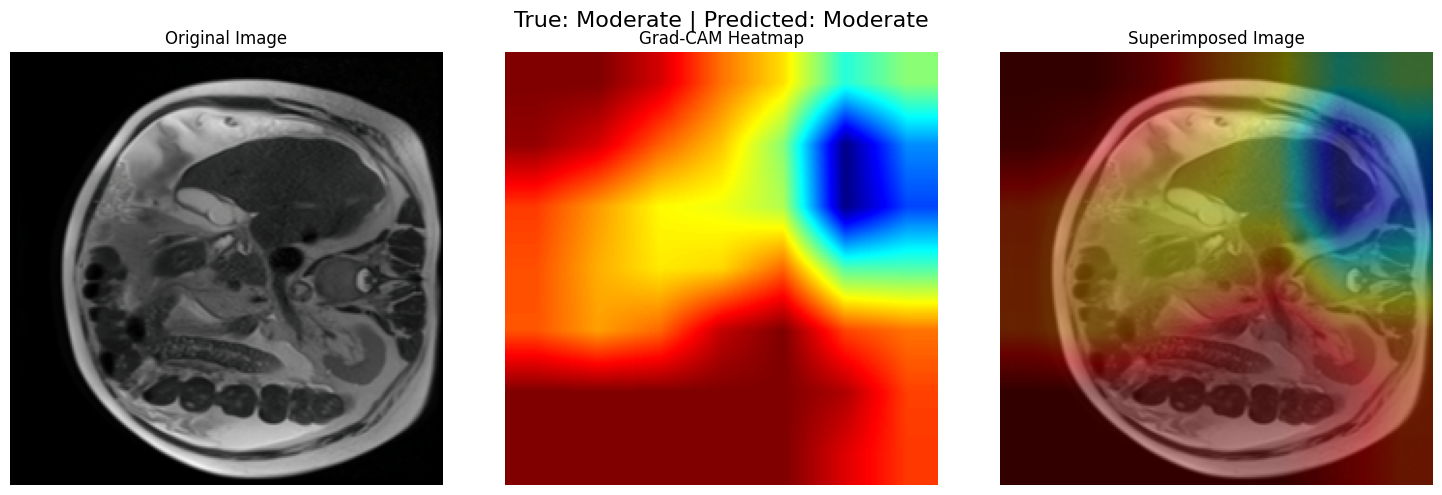

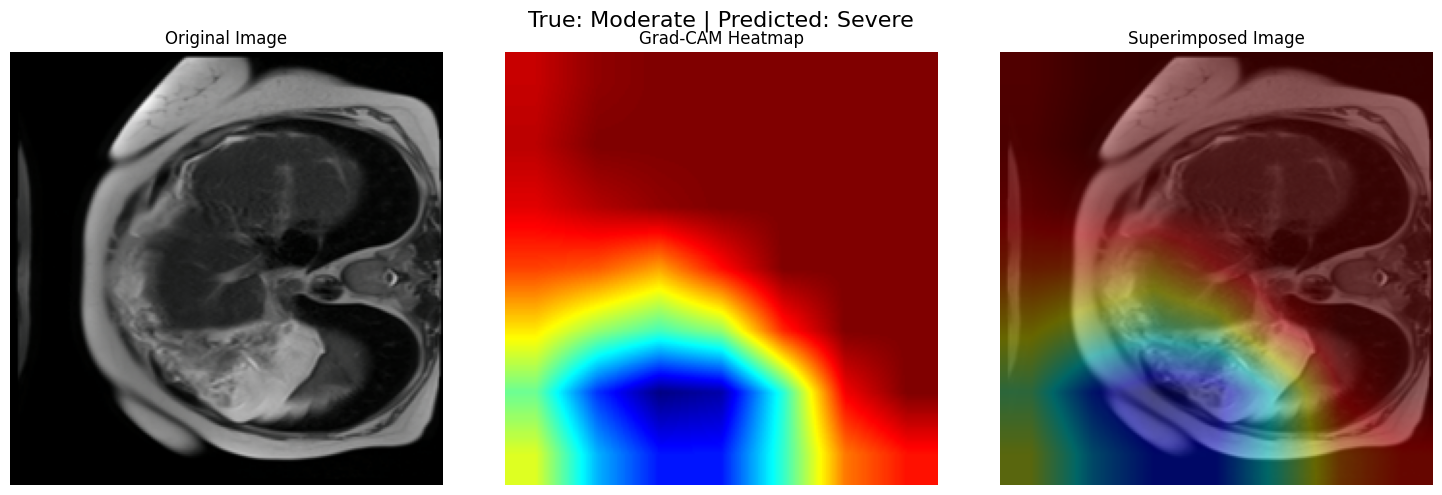

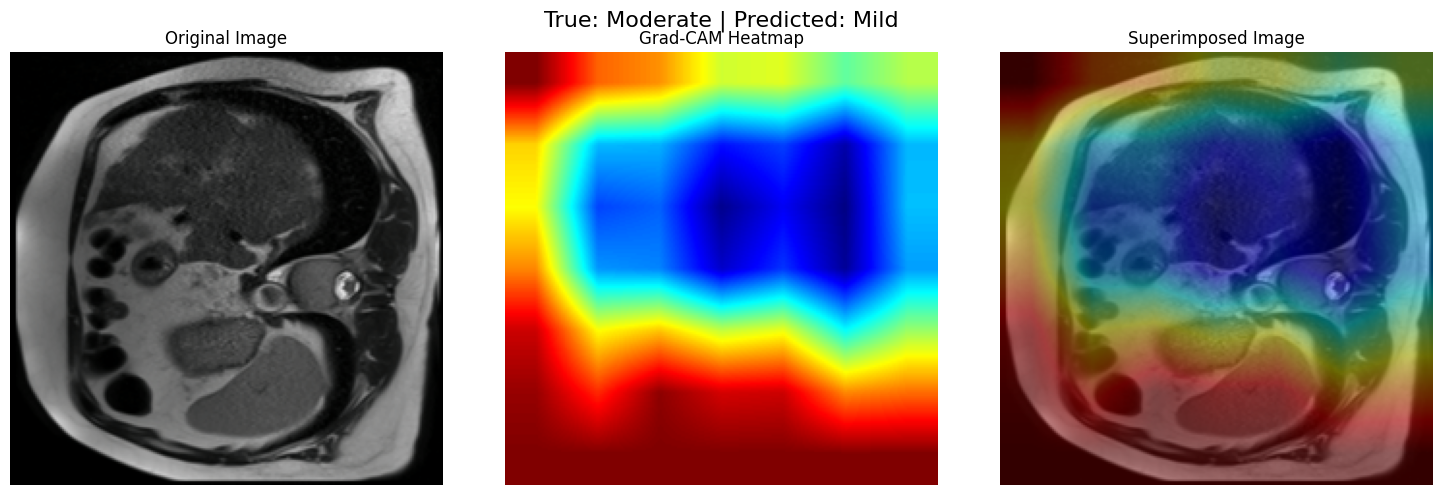

In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from itertools import cycle
import cv2

# LIME এবং Grad-CAM এর জন্য ইম্পোর্ট
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --- নতুন ফাংশন: প্রতিবার একই ফলাফল পাওয়ার জন্য সিড সেট করা ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# --- স্ক্রিপ্টের শুরুতে সিড সেট করুন ---
set_seed(42)


# --- 1. CONFIGURATION ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
TRAIN_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
VAL_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
IMAGE_SIZE = (224, 224)

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# ... (বাকি সব Helper Functions, DataFrame Creation, Dataset, Model Architectures অপরিবর্তিত থাকবে) ...
# --- 3. DATAFRAME CREATION AND MERGE ---
print("\n--- Creating DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir = os.path.join(folder_path, 'images')
                if os.path.exists(images_dir):
                    for image_file in os.listdir(images_dir):
                        mask_path = os.path.join(folder_path, 'masks', image_file)
                        if os.path.exists(mask_path):
                            image_path = os.path.join(images_dir, image_file)
                            data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    train_df = pd.merge(create_dataframe_from_ids(TRAIN_DIR, valid_ids), metadata_df, on='ID')
    val_df = pd.merge(create_dataframe_from_ids(VAL_DIR, valid_ids), metadata_df, on='ID')
    test_df = pd.merge(create_dataframe_from_ids(TEST_DIR, valid_ids), metadata_df, on='ID')

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more dataframes are empty. Check your file paths and metadata.")
    
    print(f"Successfully created and merged dataframes: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        label = torch.tensor(row['class_label'], dtype=torch.long)
        return image, mask, label

# --- 5. MODEL ARCHITECTURE DEFINITIONS ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        bs,_,h,w = e4.shape
        trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        return F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet50(weights=None)
        layers = list(base.children())
        self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.attn3 = AttentionGate(1024, 1024, 512)
        self.dec_conv3 = ConvBlock(2048, 1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.attn2 = AttentionGate(512, 512, 256)
        self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.attn1 = AttentionGate(256, 256, 128)
        self.dec_conv1 = ConvBlock(512, 256)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.attn0 = AttentionGate(64, 64, 32)
        self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1))
        d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1))
        d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1))
        return self.final_conv(self.final_up(d0))

# --- 6. LOADING MODELS ---
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except Exception as e:
        print(f"Error loading files: {e}")

# --- 7. PREDICTION & EVALUATION ---
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    all_preds1, all_preds2, all_preds3 = [], [], []
    print("\nGenerating predictions and collecting ground truths...")
    with torch.no_grad():
        for images, _, _ in tqdm(test_loader, desc="Segmentation Prediction"):
            images = images.to(device)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())
    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)
    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

# =================================================================================
# --- 8. CLASSIFICATION STAGE ---
# =================================================================================
print("\n\n--- Starting Classification Stage ---")
if not models_loaded or test_df is None:
    print("Skipping classification stage due to errors in model or data loading.")
else:
    try:
        print("\nGenerating segmentation predictions for all datasets...")
        train_dataset = LiverDataset(train_df, transform=test_transform)
        val_dataset = LiverDataset(val_df, transform=test_transform)

        def get_segmentation_predictions(dataset, desc):
            loader = DataLoader(dataset, batch_size=16, shuffle=False)
            all_preds = []
            with torch.no_grad():
                for images, _, _ in tqdm(loader, desc=desc):
                    images = images.to(device)
                    preds1, preds2, preds3 = model1(images), model2(images), model3(images)
                    ensembled = torch.sigmoid(torch.mean(torch.stack([preds1, preds2, preds3]), dim=0))
                    all_preds.append((ensembled > 0.5).float().cpu())
            return torch.cat(all_preds)

        train_pred_masks = get_segmentation_predictions(train_dataset, "Generating Train Masks")
        val_pred_masks = get_segmentation_predictions(val_dataset, "Generating Val Masks")
        test_pred_masks = (torch.sigmoid(ensembled_preds) > 0.5).float()

        print("Segmentation predictions generated successfully for all splits.")
        
        class RawClassificationDataset(Dataset):
            def __init__(self, dataframe, predicted_masks, transform):
                self.dataframe = dataframe
                self.predicted_masks = predicted_masks
                self.transform = transform
            def __len__(self): return len(self.dataframe)
            def __getitem__(self, idx):
                row = self.dataframe.iloc[idx]
                image_pil = Image.open(row['image_file_path']).convert('RGB')
                mask_pil = Image.open(row['mask_file_path']).convert('L')
                image, gt_mask = self.transform(image_pil, mask_pil)
                pred_mask = self.predicted_masks[idx]
                combined_input = torch.cat([image, gt_mask, pred_mask], dim=0)
                label = torch.tensor(row['class_label'], dtype=torch.long)
                return combined_input, label

        train_raw_dataset = RawClassificationDataset(train_df, train_pred_masks, test_transform)
        val_cls_dataset = RawClassificationDataset(val_df, val_pred_masks, test_transform)
        test_cls_dataset = RawClassificationDataset(test_df, test_pred_masks, test_transform)
        
        print("\nApplying SMOTE to balance the training data...")
        X_train, y_train = [], []
        for inputs, labels in tqdm(DataLoader(train_raw_dataset, batch_size=len(train_raw_dataset)), desc="Extracting features"):
            X_train.append(inputs.view(inputs.shape[0], -1))
            y_train.append(labels)
        X_train_flat = torch.cat(X_train, dim=0).cpu().numpy()
        y_train_labels = torch.cat(y_train, dim=0).cpu().numpy()
        
        print(f"Original training data samples per class: {np.bincount(y_train_labels)}")
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train_flat, y_train_labels)
        print(f"Resampled training data samples per class: {np.bincount(y_train_res)}")
        
        X_train_res = torch.from_numpy(X_train_res).float().view(-1, 5, IMAGE_SIZE[0], IMAGE_SIZE[1])
        y_train_res = torch.from_numpy(y_train_res).long()
        
        train_cls_dataset_smote = TensorDataset(X_train_res, y_train_res)
        train_cls_loader = DataLoader(train_cls_dataset_smote, batch_size=16, shuffle=True)
        val_cls_loader = DataLoader(val_cls_dataset, batch_size=16, shuffle=False)
        test_cls_loader = DataLoader(test_cls_dataset, batch_size=16, shuffle=False)
        print("\nClassification datasets and loaders are ready.")

        class CirrhosisClassifier(nn.Module):
            def __init__(self, n_classes=3, in_channels=5):
                super().__init__()
                self.base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                original_conv1 = self.base_model.conv1
                self.base_model.conv1 = nn.Conv2d(in_channels, original_conv1.out_channels,
                                                 kernel_size=original_conv1.kernel_size, stride=original_conv1.stride,
                                                 padding=original_conv1.padding, bias=False)
                num_ftrs = self.base_model.fc.in_features
                self.base_model.fc = nn.Linear(num_ftrs, n_classes)
            def forward(self, x): return self.base_model(x)
        
        cls_model = CirrhosisClassifier(n_classes=3, in_channels=5).to(device)
        criterion = nn.CrossEntropyLoss()
        # --- হাইপারপ্যারামিটার পরিবর্তন করা হয়েছে ---
        optimizer = torch.optim.AdamW(cls_model.parameters(), lr=5e-5) # লার্নিং রেট কমানো হয়েছে
        num_epochs = 50
        patience = 10 # Patience বাড়ানো হয়েছে
        epochs_no_improve = 0
        best_val_accuracy = 0.0
        
        print("\n--- Starting Classifier Training with Early Stopping ---")
        for epoch in range(num_epochs):
            cls_model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = cls_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            cls_model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_cls_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = cls_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
            val_accuracy = val_corrects.double() / len(val_cls_dataset)
            print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_cls_loader):.4f} | Val Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(cls_model.state_dict(), 'best_classifier_model.pth')
                epochs_no_improve = 0
                print(f"      -> ✅ New best model saved with accuracy: {best_val_accuracy:.4f}")
            else:
                epochs_no_improve += 1
                print(f"      -> ❌ No improvement for {epochs_no_improve} epochs.")
            
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
                break

        print("\n--- Training Finished ---")

        print("\n--- Evaluating on Test Set ---")
        cls_model.load_state_dict(torch.load('best_classifier_model.pth'))
        cls_model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(test_cls_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cls_model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        class_names = ['Mild', 'Moderate', 'Severe']
        # The code to generate the Classification Report and Confusion Matrix has been removed.

    except Exception as e:
        print(f"\nAn error occurred during the classification stage: {e}")

# The code for ROC curve analysis has been removed.

# =================================================================================
# --- GRAD-CAM VISUALIZATION ---
# =================================================================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _capture_gradients(self, module, grad_input, grad_output): self.gradients = grad_output[0]
    def _capture_activations(self, module, input, output): self.activations = output
    def _register_hooks(self):
        self.target_layer.register_forward_hook(self._capture_activations)
        self.target_layer.register_full_backward_hook(self._capture_gradients)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x.unsqueeze(0).to(device))
        if class_idx is None: class_idx = output.argmax(dim=1).item()
        one_hot = torch.zeros_like(output); one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        activations = self.activations.detach().cpu()
        gradients = self.gradients.detach().cpu()
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.shape[1]): activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        if torch.max(heatmap) > 0: heatmap /= torch.max(heatmap)
        return heatmap.numpy(), class_idx

def visualize_grad_cam(model, dataloader, target_layer, num_images=5):
    print("\n\n--- Generating Grad-CAM Visualizations ---")
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    grad_cam = GradCAM(model, target_layer)
    for i, (input_tensor, label) in enumerate(dataloader):
        if i >= num_images: break
        input_tensor_single = input_tensor[0]
        rgb_tensor = input_tensor_single[:3, :, :]
        original_img = inv_normalize(rgb_tensor).permute(1, 2, 0).numpy()
        original_img = (original_img * 255).astype(np.uint8)
        heatmap, predicted_idx = grad_cam(input_tensor_single)
        heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
        heatmap_img = (heatmap_resized * 255).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_color, 0.4, 0)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        true_class, pred_class = class_names[label[0].item()], class_names[predicted_idx]
        fig.suptitle(f'True: {true_class} | Predicted: {pred_class}', fontsize=16)
        axes[0].imshow(original_img); axes[0].set_title('Original Image'); axes[0].axis('off')
        axes[1].imshow(heatmap_color); axes[1].set_title('Grad-CAM Heatmap'); axes[1].axis('off')
        axes[2].imshow(superimposed_img); axes[2].set_title('Superimposed Image'); axes[2].axis('off')
        plt.tight_layout(); plt.show()

if 'cls_model' in locals():
    target_layer_for_gradcam = cls_model.base_model.layer4[-1]
    visualize_grad_cam(cls_model, test_cls_loader, target_layer_for_gradcam, num_images=3)

# The code for LIME visualizations has been removed.

Using device: cuda ⚙️

--- Creating DataFrames ---
Successfully created and merged dataframes: 5364 train, 674 val, 664 test.

Loading all three models from specified paths...
All models loaded successfully! ✅

Generating predictions and collecting ground truths...


Segmentation Prediction: 100%|██████████| 42/42 [00:33<00:00,  1.26it/s]



Ensembling predictions...


--- Starting Classification Stage ---

Generating segmentation predictions for all datasets...


Generating Train Masks: 100%|██████████| 336/336 [04:53<00:00,  1.14it/s]


Segmentation predictions generated successfully for all splits.

Applying SMOTE to balance the training data...


Extracting features: 100%|██████████| 1/1 [00:57<00:00, 57.20s/it]


Original training data samples per class: [2179 2069 1116]
Resampled training data samples per class: [2179 2179 2179]

Classification training dataset is ready.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s] 



--- Starting Classifier Training ---


Epoch 1/50: 100%|██████████| 409/409 [00:48<00:00,  8.37it/s]


Epoch 1/50 | Training Loss: 0.4483


Epoch 2/50: 100%|██████████| 409/409 [00:46<00:00,  8.86it/s]


Epoch 2/50 | Training Loss: 0.1121


Epoch 3/50: 100%|██████████| 409/409 [00:47<00:00,  8.60it/s]


Epoch 3/50 | Training Loss: 0.0699


Epoch 4/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 4/50 | Training Loss: 0.0382


Epoch 5/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 5/50 | Training Loss: 0.0473


Epoch 6/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 6/50 | Training Loss: 0.0385


Epoch 7/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 7/50 | Training Loss: 0.0284


Epoch 8/50: 100%|██████████| 409/409 [00:47<00:00,  8.67it/s]


Epoch 8/50 | Training Loss: 0.0290


Epoch 9/50: 100%|██████████| 409/409 [00:47<00:00,  8.68it/s]


Epoch 9/50 | Training Loss: 0.0115


Epoch 10/50: 100%|██████████| 409/409 [00:47<00:00,  8.69it/s]


Epoch 10/50 | Training Loss: 0.0330


Epoch 11/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 11/50 | Training Loss: 0.0308


Epoch 12/50: 100%|██████████| 409/409 [00:46<00:00,  8.74it/s]


Epoch 12/50 | Training Loss: 0.0114


Epoch 13/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 13/50 | Training Loss: 0.0172


Epoch 14/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 14/50 | Training Loss: 0.0290


Epoch 15/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 15/50 | Training Loss: 0.0140


Epoch 16/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 16/50 | Training Loss: 0.0111


Epoch 17/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 17/50 | Training Loss: 0.0351


Epoch 18/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 18/50 | Training Loss: 0.0084


Epoch 19/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 19/50 | Training Loss: 0.0013


Epoch 20/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 20/50 | Training Loss: 0.0326


Epoch 21/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 21/50 | Training Loss: 0.0046


Epoch 22/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 22/50 | Training Loss: 0.0016


Epoch 23/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 23/50 | Training Loss: 0.0007


Epoch 24/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 24/50 | Training Loss: 0.0014


Epoch 25/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 25/50 | Training Loss: 0.0563


Epoch 26/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 26/50 | Training Loss: 0.0050


Epoch 27/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 27/50 | Training Loss: 0.0009


Epoch 28/50: 100%|██████████| 409/409 [00:46<00:00,  8.70it/s]


Epoch 28/50 | Training Loss: 0.0016


Epoch 29/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 29/50 | Training Loss: 0.0072


Epoch 30/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 30/50 | Training Loss: 0.0180


Epoch 31/50: 100%|██████████| 409/409 [00:47<00:00,  8.69it/s]


Epoch 31/50 | Training Loss: 0.0154


Epoch 32/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 32/50 | Training Loss: 0.0174


Epoch 33/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 33/50 | Training Loss: 0.0095


Epoch 34/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 34/50 | Training Loss: 0.0013


Epoch 35/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 35/50 | Training Loss: 0.0004


Epoch 36/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 36/50 | Training Loss: 0.0002


Epoch 37/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 37/50 | Training Loss: 0.0256


Epoch 38/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 38/50 | Training Loss: 0.0129


Epoch 39/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 39/50 | Training Loss: 0.0017


Epoch 40/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 40/50 | Training Loss: 0.0007


Epoch 41/50: 100%|██████████| 409/409 [00:46<00:00,  8.73it/s]


Epoch 41/50 | Training Loss: 0.0006


Epoch 42/50: 100%|██████████| 409/409 [00:46<00:00,  8.72it/s]


Epoch 42/50 | Training Loss: 0.0001


Epoch 43/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 43/50 | Training Loss: 0.0001


Epoch 44/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 44/50 | Training Loss: 0.0001


Epoch 45/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 45/50 | Training Loss: 0.0002


Epoch 46/50: 100%|██████████| 409/409 [00:46<00:00,  8.70it/s]


Epoch 46/50 | Training Loss: 0.0423


Epoch 47/50: 100%|██████████| 409/409 [00:46<00:00,  8.71it/s]


Epoch 47/50 | Training Loss: 0.0026


Epoch 48/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 48/50 | Training Loss: 0.0021


Epoch 49/50: 100%|██████████| 409/409 [00:46<00:00,  8.70it/s]


Epoch 49/50 | Training Loss: 0.0003


Epoch 50/50: 100%|██████████| 409/409 [00:47<00:00,  8.70it/s]


Epoch 50/50 | Training Loss: 0.0157

--- Training Finished ---
Classifier model saved as 'final_classifier_model.pth' ✅


--- Generating LIME Explanations for Ensemble Segmentation (Per Class) ---
Explaining segmentation confidence for a 'Mild' sample...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining segmentation confidence for a 'Moderate' sample...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explaining segmentation confidence for a 'Severe' sample...


  0%|          | 0/1000 [00:00<?, ?it/s]

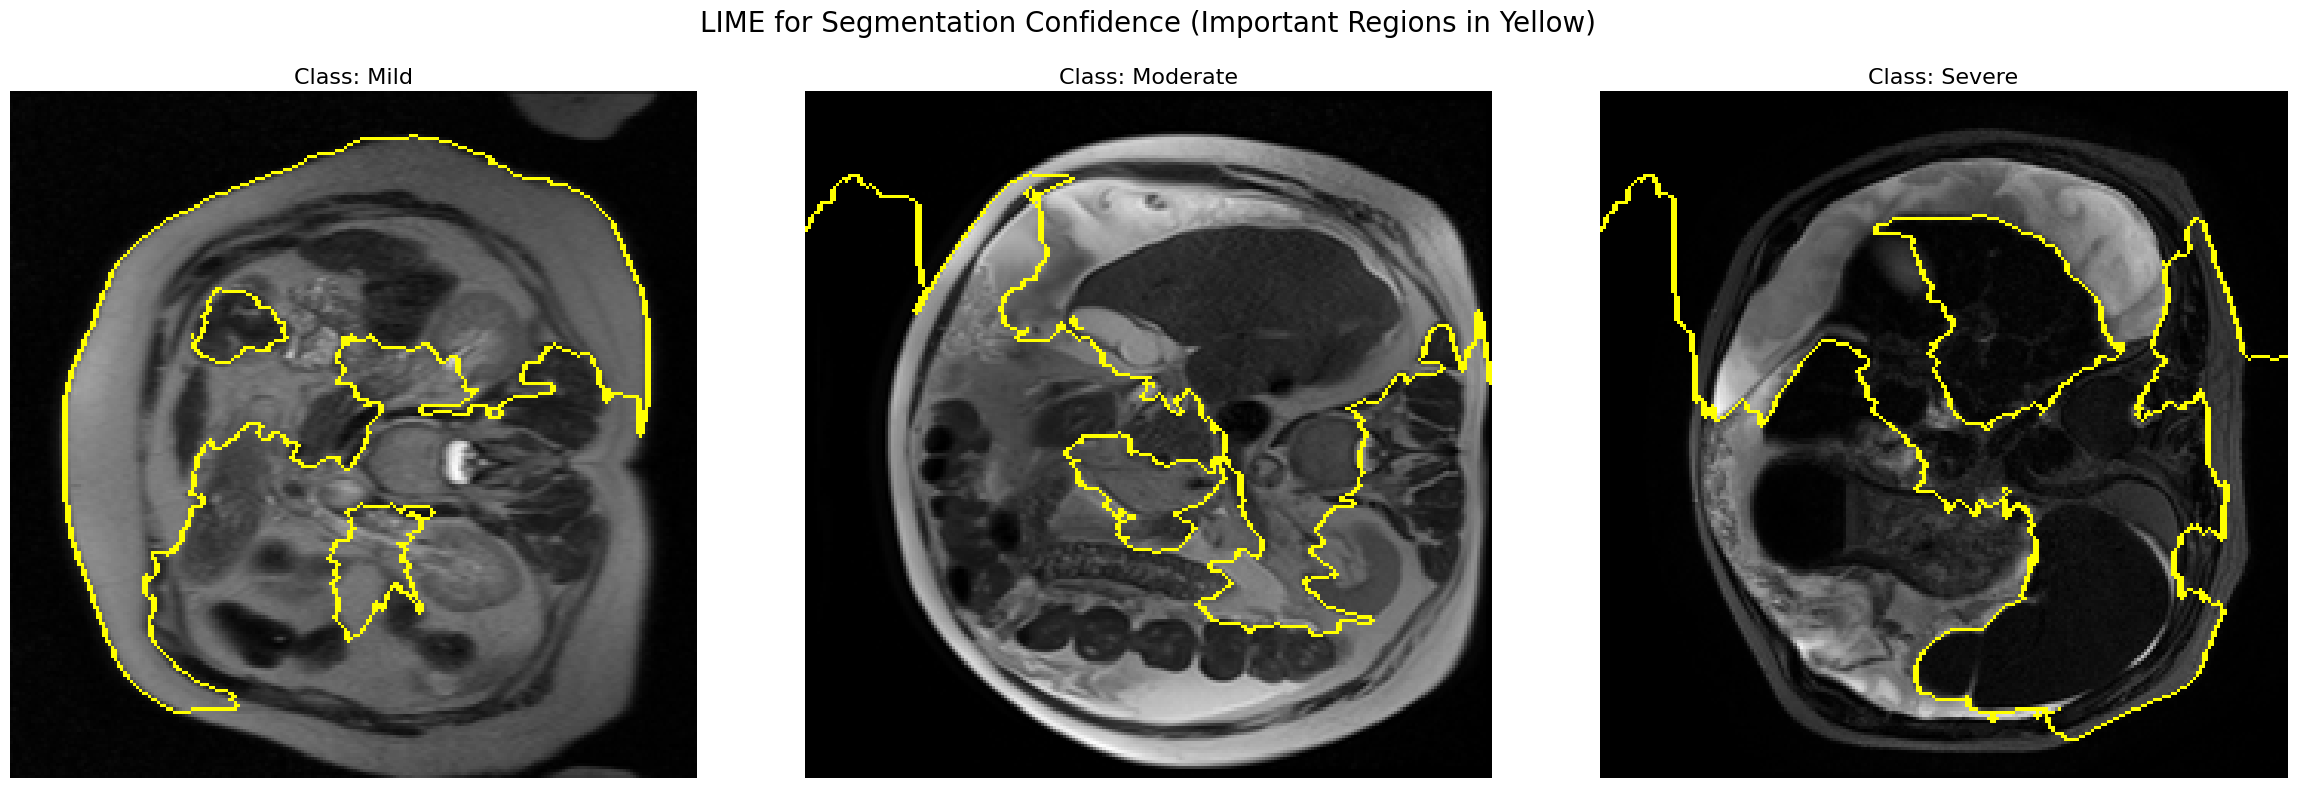

In [2]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import cv2

# LIME এর জন্য ইম্পোর্ট
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --- নতুন ফাংশন: প্রতিবার একই ফলাফল পাওয়ার জন্য সিড সেট করা ---
def set_seed(seed_value=42):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# --- স্ক্রিপ্টের শুরুতে সিড সেট করুন ---
set_seed(42)


# --- 1. CONFIGURATION ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
TRAIN_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
VAL_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
IMAGE_SIZE = (224, 224)

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. DATAFRAME CREATION AND MERGE ---
print("\n--- Creating DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir = os.path.join(folder_path, 'images')
                if os.path.exists(images_dir):
                    for image_file in os.listdir(images_dir):
                        mask_path = os.path.join(folder_path, 'masks', image_file)
                        if os.path.exists(mask_path):
                            image_path = os.path.join(images_dir, image_file)
                            data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    train_df = pd.merge(create_dataframe_from_ids(TRAIN_DIR, valid_ids), metadata_df, on='ID')
    val_df = pd.merge(create_dataframe_from_ids(VAL_DIR, valid_ids), metadata_df, on='ID')
    test_df = pd.merge(create_dataframe_from_ids(TEST_DIR, valid_ids), metadata_df, on='ID')

    if train_df.empty or val_df.empty or test_df.empty:
        raise ValueError("One or more dataframes are empty. Check your file paths and metadata.")
    
    print(f"Successfully created and merged dataframes: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        label = torch.tensor(row['class_label'], dtype=torch.long)
        return image, mask, label

# --- 5. MODEL ARCHITECTURE DEFINITIONS ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        bs,_,h,w = e4.shape
        trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        return F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet50(weights=None)
        layers = list(base.children())
        self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.attn3 = AttentionGate(1024, 1024, 512)
        self.dec_conv3 = ConvBlock(2048, 1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.attn2 = AttentionGate(512, 512, 256)
        self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.attn1 = AttentionGate(256, 256, 128)
        self.dec_conv1 = ConvBlock(512, 256)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.attn0 = AttentionGate(64, 64, 32)
        self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1))
        d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1))
        d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1))
        return self.final_conv(self.final_up(d0))

# --- 6. LOADING MODELS ---
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except Exception as e:
        print(f"Error loading files: {e}")

# --- 7. PREDICTION & EVALUATION ---
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    all_preds1, all_preds2, all_preds3 = [], [], []
    print("\nGenerating predictions and collecting ground truths...")
    with torch.no_grad():
        for images, _, _ in tqdm(test_loader, desc="Segmentation Prediction"):
            images = images.to(device)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())
    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)
    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

# =================================================================================
# --- 8. CLASSIFICATION STAGE ---
# =================================================================================
print("\n\n--- Starting Classification Stage ---")
if not models_loaded or test_df is None:
    print("Skipping classification stage due to errors in model or data loading.")
else:
    try:
        print("\nGenerating segmentation predictions for all datasets...")
        train_dataset = LiverDataset(train_df, transform=test_transform)
        
        def get_segmentation_predictions(dataset, desc):
            loader = DataLoader(dataset, batch_size=16, shuffle=False)
            all_preds = []
            with torch.no_grad():
                for images, _, _ in tqdm(loader, desc=desc):
                    images = images.to(device)
                    preds1, preds2, preds3 = model1(images), model2(images), model3(images)
                    ensembled = torch.sigmoid(torch.mean(torch.stack([preds1, preds2, preds3]), dim=0))
                    all_preds.append((ensembled > 0.5).float().cpu())
            return torch.cat(all_preds)

        train_pred_masks = get_segmentation_predictions(train_dataset, "Generating Train Masks")
        test_pred_masks = (torch.sigmoid(ensembled_preds) > 0.5).float()

        print("Segmentation predictions generated successfully for all splits.")
        
        class RawClassificationDataset(Dataset):
            def __init__(self, dataframe, predicted_masks, transform):
                self.dataframe = dataframe
                self.predicted_masks = predicted_masks
                self.transform = transform
            def __len__(self): return len(self.dataframe)
            def __getitem__(self, idx):
                row = self.dataframe.iloc[idx]
                image_pil = Image.open(row['image_file_path']).convert('RGB')
                mask_pil = Image.open(row['mask_file_path']).convert('L')
                image, gt_mask = self.transform(image_pil, mask_pil)
                pred_mask = self.predicted_masks[idx]
                combined_input = torch.cat([image, gt_mask, pred_mask], dim=0)
                label = torch.tensor(row['class_label'], dtype=torch.long)
                return combined_input, label

        train_raw_dataset = RawClassificationDataset(train_df, train_pred_masks, test_transform)
        
        print("\nApplying SMOTE to balance the training data...")
        X_train, y_train = [], []
        for inputs, labels in tqdm(DataLoader(train_raw_dataset, batch_size=len(train_raw_dataset)), desc="Extracting features"):
            X_train.append(inputs.view(inputs.shape[0], -1))
            y_train.append(labels)
        X_train_flat = torch.cat(X_train, dim=0).cpu().numpy()
        y_train_labels = torch.cat(y_train, dim=0).cpu().numpy()
        
        print(f"Original training data samples per class: {np.bincount(y_train_labels)}")
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train_flat, y_train_labels)
        print(f"Resampled training data samples per class: {np.bincount(y_train_res)}")
        
        X_train_res = torch.from_numpy(X_train_res).float().view(-1, 5, IMAGE_SIZE[0], IMAGE_SIZE[1])
        y_train_res = torch.from_numpy(y_train_res).long()
        
        train_cls_dataset_smote = TensorDataset(X_train_res, y_train_res)
        train_cls_loader = DataLoader(train_cls_dataset_smote, batch_size=16, shuffle=True)
        print("\nClassification training dataset is ready.")

        class CirrhosisClassifier(nn.Module):
            def __init__(self, n_classes=3, in_channels=5):
                super().__init__()
                self.base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                original_conv1 = self.base_model.conv1
                self.base_model.conv1 = nn.Conv2d(in_channels, original_conv1.out_channels,
                                                  kernel_size=original_conv1.kernel_size, stride=original_conv1.stride,
                                                  padding=original_conv1.padding, bias=False)
                num_ftrs = self.base_model.fc.in_features
                self.base_model.fc = nn.Linear(num_ftrs, n_classes)
            def forward(self, x): return self.base_model(x)
        
        cls_model = CirrhosisClassifier(n_classes=3, in_channels=5).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(cls_model.parameters(), lr=5e-5)
        num_epochs = 50 
        
        print("\n--- Starting Classifier Training ---")
        for epoch in range(num_epochs):
            cls_model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = cls_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {running_loss/len(train_cls_loader):.4f}")

        print("\n--- Training Finished ---")
        torch.save(cls_model.state_dict(), 'final_classifier_model.pth')
        print("Classifier model saved as 'final_classifier_model.pth' ✅")

    except Exception as e:
        print(f"\nAn error occurred during the classification stage: {e}")
        
class_names = ['Mild', 'Moderate', 'Severe']
# =================================================================================
# --- 11. LIME FOR SEGMENTATION CONFIDENCE ---
# =================================================================================
def ensemble_predict_for_lime(numpy_images):
    preprocess_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    model1.eval(); model2.eval(); model3.eval()
    with torch.no_grad():
        batch_outputs = []
        for img_np in numpy_images:
            img_pil = Image.fromarray(img_np.astype('uint8'), 'RGB')
            img_tensor = preprocess_transform(img_pil).unsqueeze(0).to(device)
            pred1, pred2, pred3 = model1(img_tensor), model2(img_tensor), model3(img_tensor)
            ensembled_logits = torch.mean(torch.stack([pred1, pred2, pred3]), dim=0)
            ensembled_probs = torch.sigmoid(ensembled_logits)
            predicted_mask = (ensembled_probs > 0.5).float()
            confidence_score = 0.0 if predicted_mask.sum() == 0 else ensembled_probs[predicted_mask == 1].mean().item()
            batch_outputs.append([1 - confidence_score, confidence_score])
    return np.array(batch_outputs)

if models_loaded and test_df is not None:
    print("\n\n--- Generating LIME Explanations for Ensemble Segmentation (Per Class) ---")
    
    lime_samples_df = test_df.drop_duplicates(subset=['class_label']).sort_values('class_label')
    
    if len(lime_samples_df) > 0:
        num_classes_found = len(lime_samples_df)
        fig, axes = plt.subplots(1, num_classes_found, figsize=(8 * num_classes_found, 8))
        if num_classes_found == 1:
             axes = [axes]
        fig.suptitle("LIME for Segmentation Confidence (Important Regions in Yellow)", fontsize=20)
        
        explainer = lime_image.LimeImageExplainer()

        for i, (index, row) in enumerate(lime_samples_df.iterrows()):
            class_name = row['class_name']
            image_path = row['image_file_path']
            original_image_np = np.array(Image.open(image_path).convert('RGB').resize(IMAGE_SIZE))
            
            print(f"Explaining segmentation confidence for a '{class_name}' sample...")
            
            explanation = explainer.explain_instance(
                original_image_np, 
                ensemble_predict_for_lime, 
                top_labels=1, 
                hide_color=0, 
                num_samples=1000
            )
            
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0], 
                positive_only=True, 
                num_features=10, 
                hide_rest=False
            )
            
            axes[i].imshow(mark_boundaries(temp, mask, color=(1, 1, 0)))
            axes[i].set_title(f"Class: {class_name}", fontsize=16)
            axes[i].axis('off')
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print("Could not find representative samples for LIME segmentation explanation.")